In [59]:
import pandas as pd

# 파일 경로
file1 = 'df_merged_solar.csv'
file2 = 'df_merged_solar2.csv'

# 데이터 불러오기
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# 데이터 결합
df_merged = pd.concat([df1, df2], ignore_index=True)

# 결과 저장 (선택)
df_merged.to_csv('df_merged_solar+solar2.csv', index=False)
df_merged = df_merged[df_merged['발전구분'] != '(군산)영암F1태양광']

# 결합된 데이터 확인
print(df_merged.shape)
print(df_merged.head())
# "발전구분"이 "(군산)영암F1태양광"인 행 제거




(196890, 15)
             일자        발전구분  설비용량(MW)  시간  발전량(kWh)  연식(년)  지점명  기온(°C)  \
365  2023-01-01  (군산)삼랑진태양광       2.0   1       0.0   14.8  양산시     1.9   
366  2023-01-02  (군산)삼랑진태양광       2.0   1       0.0   14.8  양산시     3.2   
367  2023-01-03  (군산)삼랑진태양광       2.0   1       0.0   14.8  양산시     1.8   
368  2023-01-04  (군산)삼랑진태양광       2.0   1       0.0   14.8  양산시     0.7   
369  2023-01-05  (군산)삼랑진태양광       2.0   1       0.0   14.8  양산시    -1.1   

     강수량(mm)  풍속(m/s)  풍향(16방위)  습도(%)  일사(MJ/m2)  적설(cm)  하늘상태  
365      0.0      2.4     180.0   54.0        0.0     0.0   1.0  
366      0.0      1.7     320.0   32.0        0.0     0.0   4.0  
367      0.0      3.7     270.0   25.0        0.0     0.0   1.0  
368      0.0      2.8     290.0   37.0        0.0     0.0   1.0  
369      0.0      0.0       0.0   66.0        0.0     0.0   1.0  


In [6]:
def summarize_unique_values_full(df, threshold=50):
    print("✅ 컬럼별 유니크 값 및 개수 요약\n")
    
    for col in df.columns:
        unique_vals = df[col].dropna().unique()
        nunique = len(unique_vals)
        
        print(f"\n🔹 {col} ({df[col].dtype}) → 고유값 {nunique}개")

        if nunique > threshold:
            print("   ⮑ 연속형 데이터로 판단됨 (고유값 50개 초과)\n")
        else:
            value_counts = df[col].value_counts(dropna=True)
            for val, count in value_counts.items():
                print(f"   • {val} : {count}개")

# 실행
summarize_unique_values_full(df_merged)

✅ 컬럼별 유니크 값 및 개수 요약


🔹 일자 (datetime64[ns]) → 고유값 2556개
   ⮑ 연속형 데이터로 판단됨 (고유값 50개 초과)


🔹 발전구분 (object) → 고유값 6개
   • 영암에프원태양광b : 56934개
   • 안산연성정수장태양광 : 56886개
   • 세종시폐기물매립장태양광 : 56814개
   • (군산)삼랑진태양광 : 17520개
   • (군산)영암F1태양광 : 8760개
   • 태안#9,10 수상태양광 : 8736개

🔹 설비용량(MW) (float64) → 고유값 5개
   • 13.296 : 65694개
   • 1.49 : 56886개
   • 1.628 : 56814개
   • 2.0 : 17520개
   • 1.836 : 8736개

🔹 시간 (int64) → 고유값 24개
   • 24 : 8586개
   • 2 : 8568개
   • 23 : 8568개
   • 22 : 8568개
   • 21 : 8568개
   • 20 : 8568개
   • 19 : 8568개
   • 18 : 8568개
   • 17 : 8568개
   • 16 : 8568개
   • 15 : 8568개
   • 14 : 8568개
   • 1 : 8568개
   • 12 : 8568개
   • 11 : 8568개
   • 10 : 8568개
   • 9 : 8568개
   • 8 : 8568개
   • 7 : 8568개
   • 6 : 8568개
   • 5 : 8568개
   • 4 : 8568개
   • 3 : 8568개
   • 13 : 8568개

🔹 발전량(kWh) (float64) → 고유값 16997개
   ⮑ 연속형 데이터로 판단됨 (고유값 50개 초과)


🔹 연식(년) (float64) → 고유값 81개
   ⮑ 연속형 데이터로 판단됨 (고유값 50개 초과)


🔹 지점명 (object) → 고유값 5개
   • 목포 : 65694개
   • 수원 : 56886개
   • 청주 : 56814개
  

In [9]:
import pandas as pd

# 파일 불러오기
file1 = 'df_merged_solar.csv'      # (군산)영암F1 있음
file2 = 'df_merged_solar2.csv'     # 영암에프원태양광b 있음

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# 컬럼명 정리 및 datetime 변환
df1.columns = df1.columns.str.strip()
df2.columns = df2.columns.str.strip()
df1['일자'] = pd.to_datetime(df1['일자'], errors='coerce')
df2['일자'] = pd.to_datetime(df2['일자'], errors='coerce')

# 1. 영암에프원태양광b의 마지막 날짜를 df2에서 구함
last_date = df2[df2['발전구분'] == '영암에프원태양광b']['일자'].max()
print(f"📌 df2 기준 '영암에프원태양광b' 마지막 일자: {last_date}")

# 2. df1에서 (군산)영암F1태양광의 그 이후 날짜 데이터만 추출
mask = (df1['발전구분'] == '(군산)영암F1태양광') & (df1['일자'] > last_date)
df_군산추가 = df1[mask].copy()
df_군산추가['발전구분'] = '영암에프원태양광b'

# 3. df1에서 (군산)영암F1태양광 제외한 나머지
df1_others = df1[df1['발전구분'] != '(군산)영암F1태양광'].copy()

# 4. 최종 병합: df2 + df1_others + 군산추가
df_merged = pd.concat([df2, df1_others, df_군산추가], ignore_index=True)

# 5. 저장
df_merged.to_csv('df_merged_solar_cleaned.csv', index=False)

# 6. 확인
print(f"✅ 추가된 (군산)영암F1 행 수: {df_군산추가.shape[0]}")
print(f"✅ 최종 병합 데이터 행 수: {df_merged.shape[0]}")
print("✅ 발전소별 개수:\n", df_merged['발전구분'].value_counts())


📌 df2 기준 '영암에프원태양광b' 마지막 일자: 2023-06-30 00:00:00
✅ 추가된 (군산)영암F1 행 수: 4416
✅ 최종 병합 데이터 행 수: 201306
✅ 발전소별 개수:
 발전구분
영암에프원태양광b        61350
안산연성정수장태양광       56886
세종시폐기물매립장태양광     56814
(군산)삼랑진태양광       17520
태안#9,10 수상태양광     8736
Name: count, dtype: int64


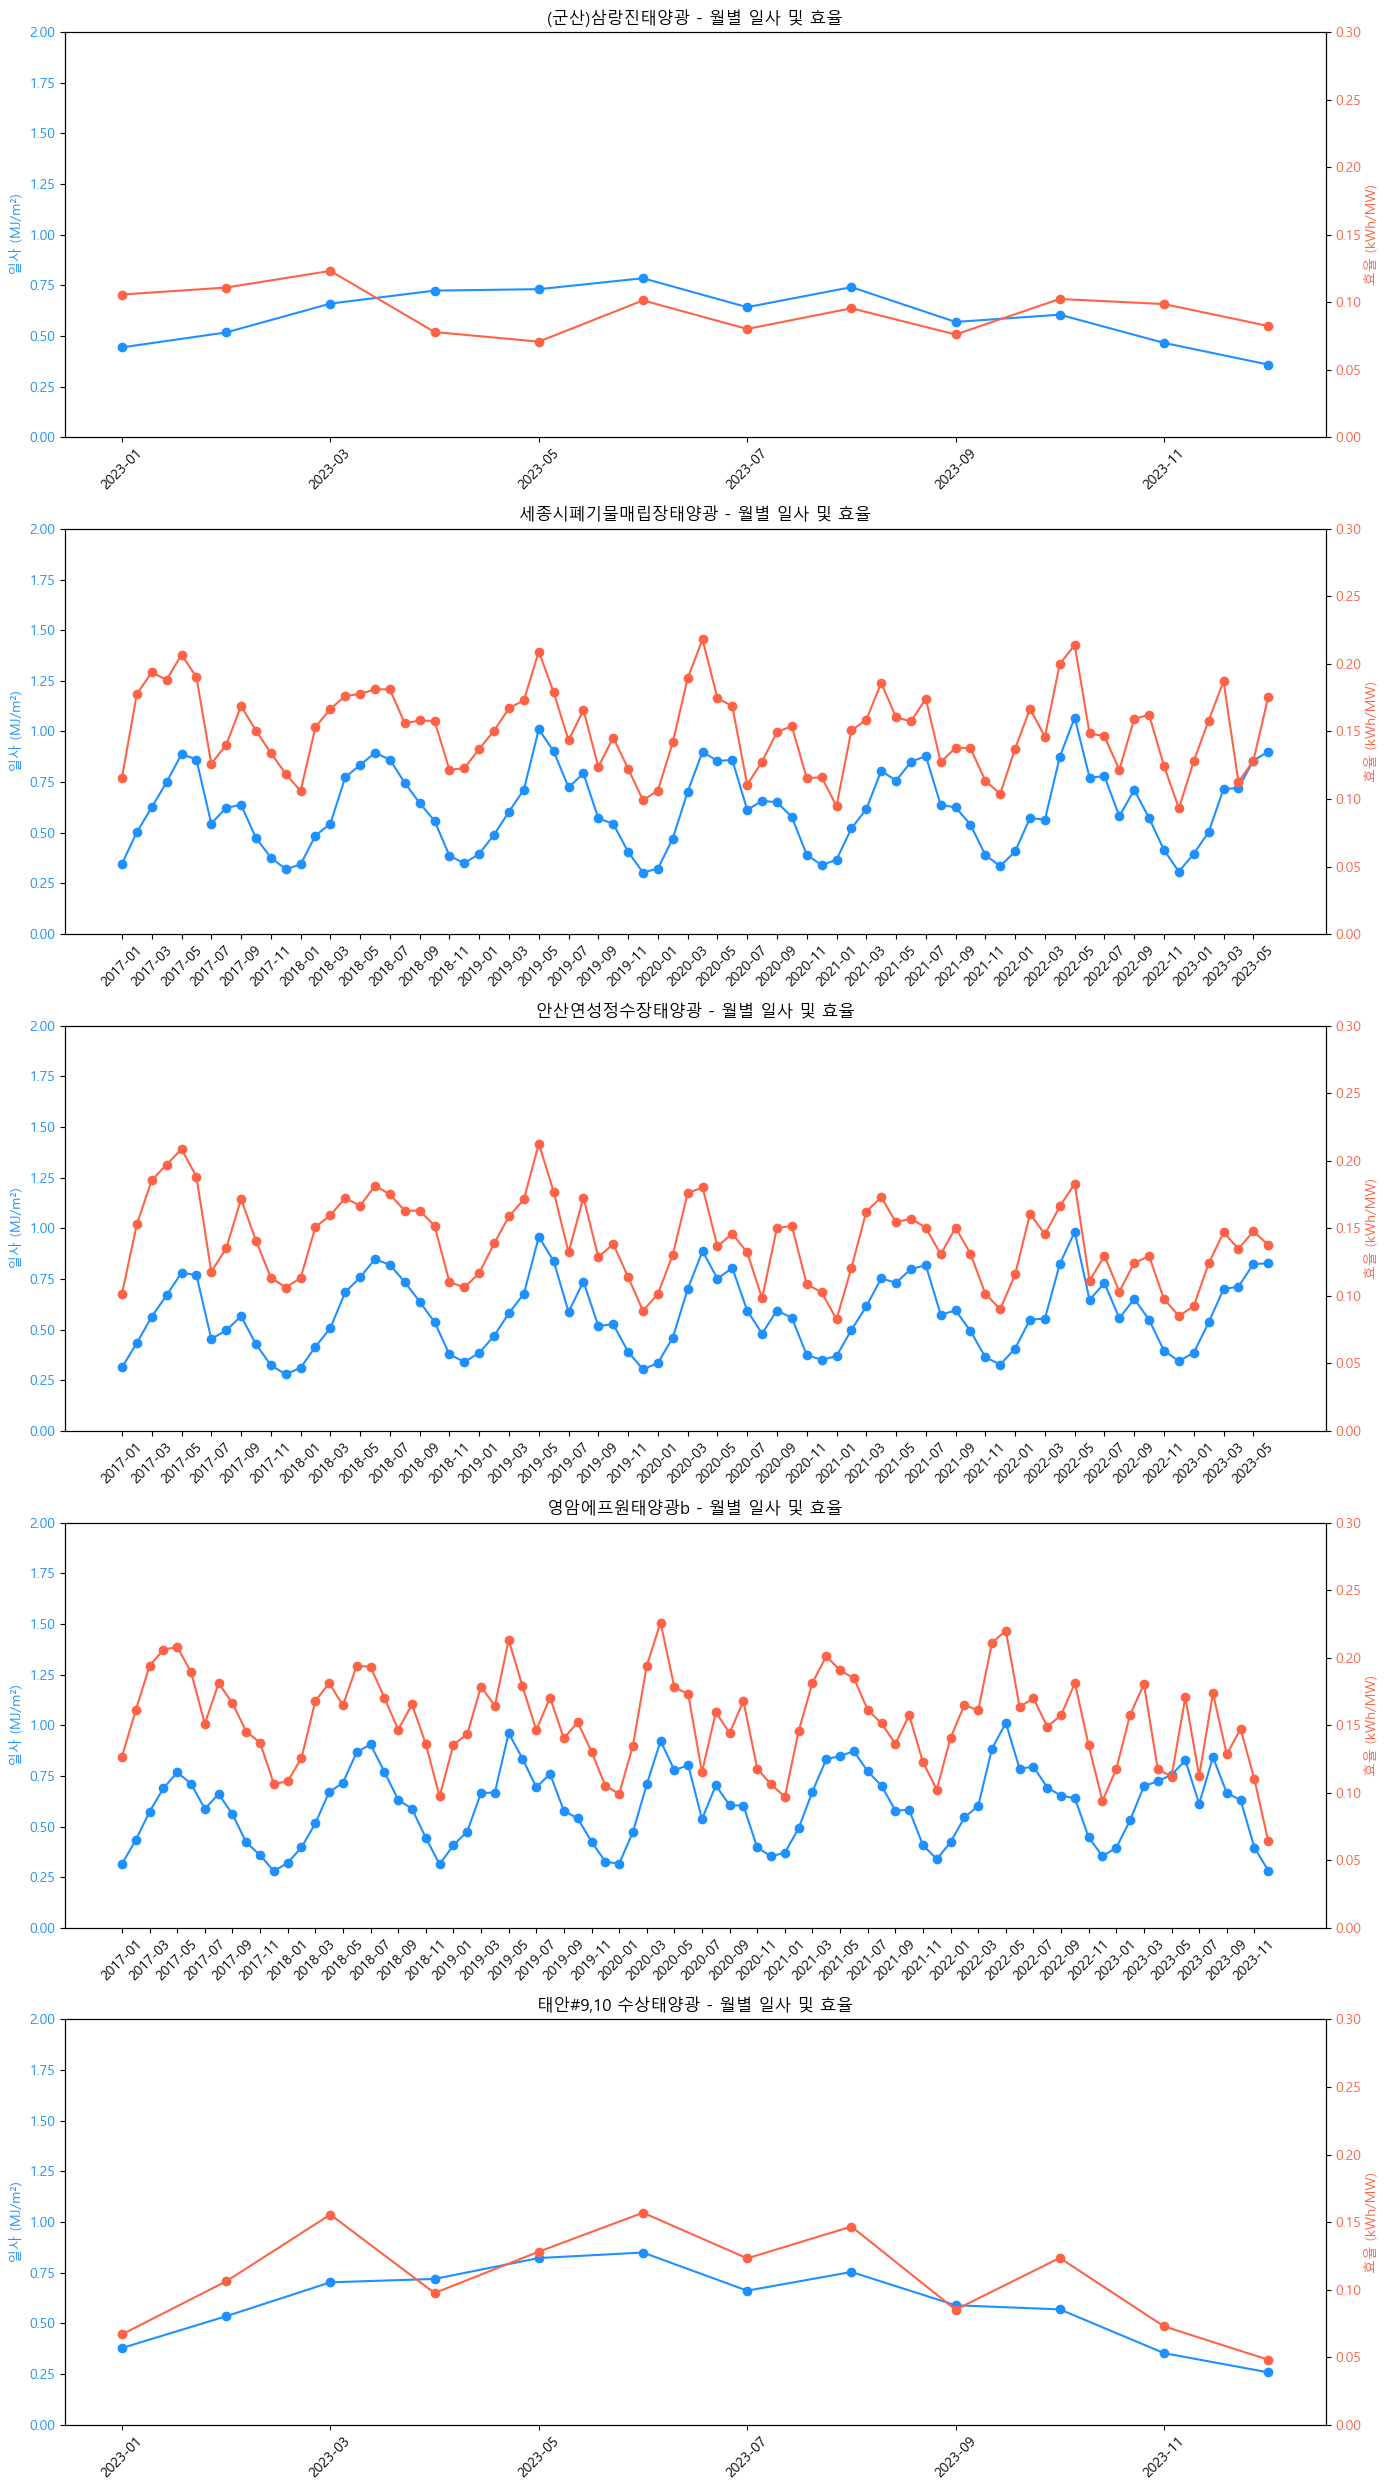

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ✅ 사용자 설정 y축 범위
irr_min, irr_max = 0, 2   # 일사 (MJ/m²)
eff_min, eff_max = 0, 0.3      # 효율 (kWh/MW)

# ✅ 연월 및 효율 계산
df_merged['일자'] = pd.to_datetime(df_merged['일자'], errors='coerce')
df_merged['연월'] = df_merged['일자'].dt.to_period('M').astype(str)
df_merged['효율'] = df_merged['발전량(kWh)'] / (df_merged['설비용량(MW)'] * 1000)

# ✅ 결측 제거 및 월별 평균
df_cleaned = df_merged.dropna(subset=['연월', '발전구분', '일사(MJ/m2)', '효율'])
grouped = df_cleaned.groupby(['발전구분', '연월']).agg({
    '일사(MJ/m2)': 'mean',
    '효율': 'mean'
}).reset_index()

# ✅ 발전소 리스트
plants = grouped['발전구분'].unique()
num_plants = len(plants)

# ✅ 전체 Figure 생성 (세로로 나열)
fig, axes = plt.subplots(num_plants, 1, figsize=(14, 5 * num_plants))

if num_plants == 1:
    axes = [axes]  # subplot이 1개일 경우도 리스트로 처리

for i, plant in enumerate(plants):
    ax1 = axes[i]
    sub = grouped[grouped['발전구분'] == plant]
    x = sub['연월']

    # 일사 (왼쪽 y축)
    ax1.plot(x, sub['일사(MJ/m2)'], color='dodgerblue', marker='o', label='일사 (MJ/m²)')
    ax1.set_ylabel('일사 (MJ/m²)', color='dodgerblue')
    ax1.tick_params(axis='y', labelcolor='dodgerblue')
    ax1.set_ylim(irr_min, irr_max)

    # 효율 (오른쪽 y축)
    ax2 = ax1.twinx()
    ax2.plot(x, sub['효율'], color='tomato', marker='o', label='효율')
    ax2.set_ylabel('효율 (kWh/MW)', color='tomato')
    ax2.tick_params(axis='y', labelcolor='tomato')
    ax2.set_ylim(eff_min, eff_max)

    # x축 설정
    ax1.set_xticks(x[::2])
    ax1.set_xticklabels(x[::2], rotation=45)

    ax1.set_title(f'{plant} - 월별 일사 및 효율')

# ✅ 전체 레이아웃 조정 및 저장
plt.tight_layout()
plt.savefig('solar3_일사량-발전효율.png', dpi=300)
plt.show()

df_merged = df_merged.drop(columns=['효율', '연월'], errors='ignore')




In [12]:
print(df_merged['발전구분'].unique())


['세종시폐기물매립장태양광' '안산연성정수장태양광' '영암에프원태양광b' '(군산)삼랑진태양광' '태안#9,10 수상태양광']


In [13]:
import pandas as pd
import pvlib

# 1) 위도·경도 정보 (지점 기준) - 반드시 실제 위치 기반으로 업데이트 필요
location_info = {
    '(군산)삼랑진태양광': (35.3867, 128.8963),   # 경남 밀양시 삼랑진읍 부근
    '태안#9,10 수상태양광': (36.7868, 126.2987), # 충남 태안군 원북면 부근
    '세종시폐기물매립장태양광': (36.5287, 127.2875), # 세종시 연서면 일대
    '안산연성정수장태양광': (37.3219, 126.8337), # 경기도 안산시 단원구 부근
    '영암에프원태양광b': (34.7577, 126.3910),    # 전남 영암 F1 경기장 부근
}

# 2) 시간 형변환 및 24시 처리
df_merged['시간'] = df_merged['시간'].astype(int)
df_merged['시간조정'] = df_merged['시간'] % 24
df_merged['일자조정'] = pd.to_datetime(df_merged['일자']) + pd.to_timedelta((df_merged['시간'] // 24), unit='D')

# 3) '일시' 컬럼 생성 + 타임존 지정 (Asia/Seoul)
df_merged['일시'] = pd.to_datetime(
    df_merged['일자조정'].dt.strftime('%Y-%m-%d') + ' ' + df_merged['시간조정'].astype(str) + ':00:00'
)
df_merged['일시'] = df_merged['일시'].dt.tz_localize('Asia/Seoul')

# 4) 태양 위치 계산 함수
def compute_solar_pos(row):
    plant = row['발전구분']
    dt = row['일시']
    if plant not in location_info:
        return pd.Series([None, None])
    lat, lon = location_info[plant]
    loc = pvlib.location.Location(lat, lon, tz='Asia/Seoul')
    pos = loc.get_solarposition(times=[dt])
    return pd.Series([pos['apparent_elevation'].iloc[0], pos['azimuth'].iloc[0]])

# 5) 계산 적용
df_merged[['태양고도', '방위각']] = df_merged.apply(compute_solar_pos, axis=1)

# 6) 고도가 0 이하인 경우 방위각 결측 처리
df_merged.loc[df_merged['태양고도'] <= 0, '방위각'] = None

# 7) 시간대별 평균 고도 계산 (정상 확인용)
summary_hour = df_merged.groupby(df_merged['일시'].dt.hour)['태양고도'].mean().reset_index()
summary_hour.columns = ['시간대', '평균 고도 (°)']
print(summary_hour)

# 저장 원할 경우 주석 해제
# summary_hour.to_csv('평균_고도_시간대별.csv', index=False)


    시간대  평균 고도 (°)
0     0 -52.466903
1     1 -52.616648
2     2 -47.366425
3     3 -38.928042
4     4 -28.761714
5     5 -17.647436
6     6  -5.970023
7     7   5.793509
8     8  17.438369
9     9  28.600856
10   10  38.926439
11   11  47.645150
12   12  53.347088
13   13  53.635260
14   14  48.280818
15   15  39.714921
16   16  29.460592
17   17  18.326371
18   18   6.690493
19   19  -5.086831
20   20 -16.798788
21   21 -27.978912
22   22 -38.256371
23   23 -46.877748


In [14]:
df_merged = df_merged.drop(columns=[
    '시간조정', '일자조정', '일시', 'sun_elevation', 'sun_azimuth', 'hour'
], errors='ignore')
df_merged.tail()

,발전구분,일자,설비용량(MW),시간,발전량(kWh),연식(년),지점명,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),일사(MJ/m2),적설(cm),하늘상태,태양고도,방위각
201301,영암에프원태양광b,2023-12-27,13.296,24,0.0,11.1,목포,3.6,0.0,0.6,290.0,89.0,0.0,0.0,3.0,-76.206788,NaN
201302,영암에프원태양광b,2023-12-28,13.296,24,0.0,11.1,목포,2.3,0.0,2.4,20.0,90.0,0.0,0.0,3.0,-76.107448,NaN
201303,영암에프원태양광b,2023-12-29,13.296,24,0.0,11.1,목포,2.8,0.0,2.0,50.0,84.0,0.0,0.0,1.0,-76.001616,NaN
201304,영암에프원태양광b,2023-12-30,13.296,24,0.0,11.1,목포,8.9,0.4,1.5,230.0,96.0,0.0,0.0,4.0,-75.889432,NaN
201305,영암에프원태양광b,2023-12-31,13.296,24,0.0,11.1,목포,5.1,0.0,3.6,20.0,80.0,0.0,0.0,4.0,-75.771032,NaN


In [15]:
import numpy as np

df_merged.loc[df_merged['태양고도'] < 0, '태양고도'] = 0
df_merged.loc[df_merged['태양고도'] <= 0, '방위각'] = np.nan

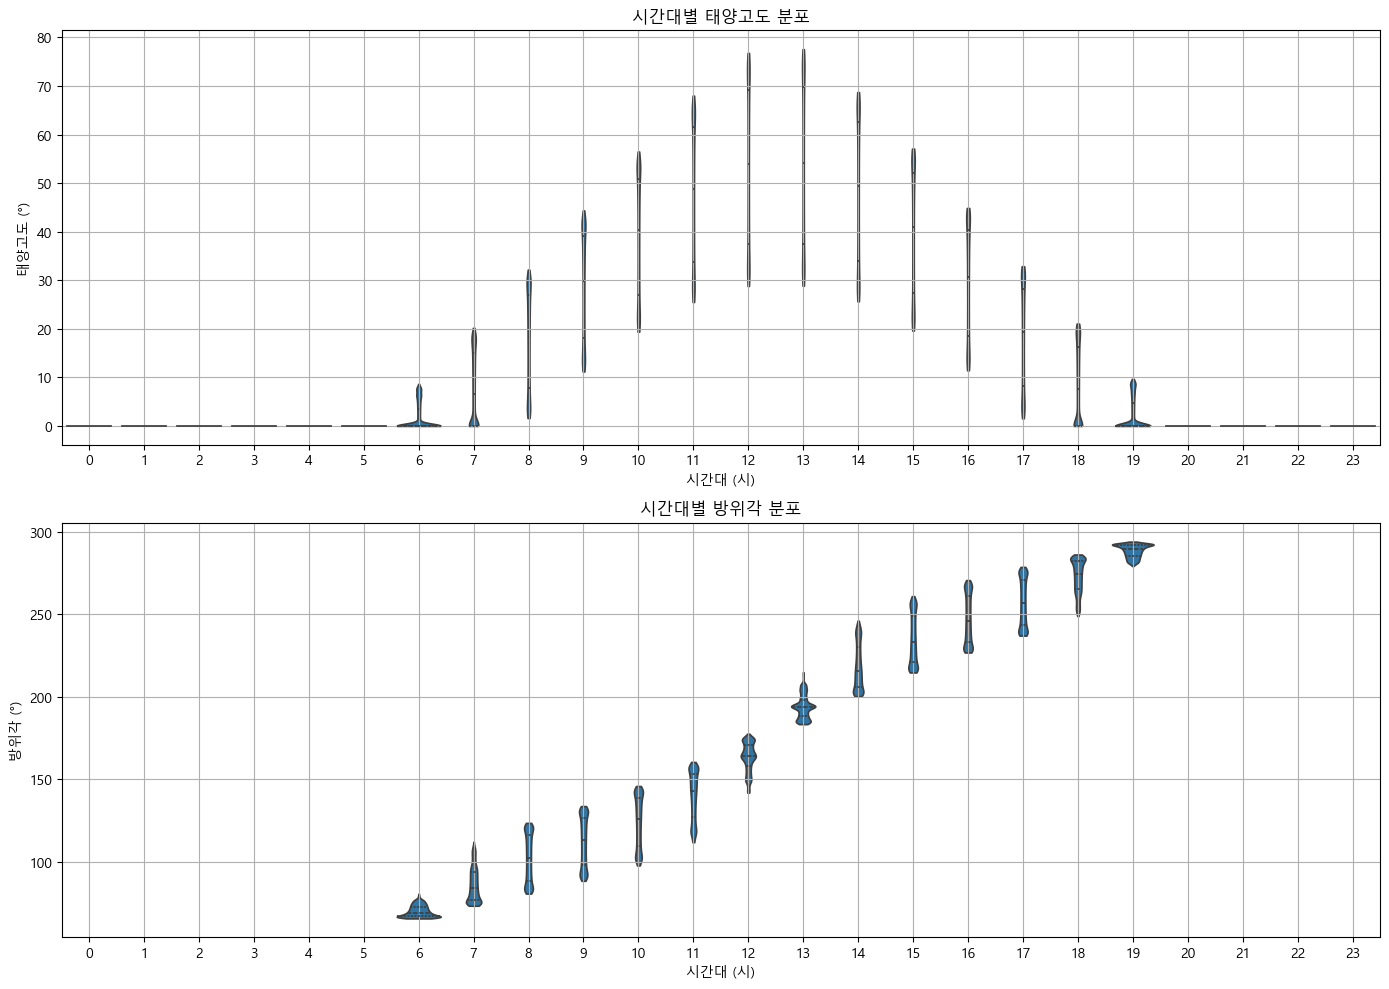

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 시간대 컬럼 생성 (시간을 0~23시로 정규화)
df_merged['시간대'] = df_merged['시간'] % 24

# 2. 그래프 생성 및 저장
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10))

# (1) 태양고도 분포
sns.violinplot(data=df_merged, x='시간대', y='태양고도', inner='quartile', cut=0, ax=axes[0])
axes[0].set_title('시간대별 태양고도 분포')
axes[0].set_xlabel('시간대 (시)')
axes[0].set_ylabel('태양고도 (°)')
axes[0].grid(True)

# (2) 방위각 분포
sns.violinplot(data=df_merged, x='시간대', y='방위각', inner='quartile', cut=0, ax=axes[1])
axes[1].set_title('시간대별 방위각 분포')
axes[1].set_xlabel('시간대 (시)')
axes[1].set_ylabel('방위각 (°)')
axes[1].grid(True)

plt.tight_layout()
plt.savefig('태양고도_방위각_분포.png', dpi=300)  # 🔽 여기서 저장됨
plt.show()

# 3. 임시 컬럼 삭제
df_merged.drop(columns=['시간대'], inplace=True)


In [18]:
df_merged = df_merged.sort_values(by=['일자', '시간']).reset_index(drop=True)


In [19]:
df_merged

,발전구분,일자,설비용량(MW),시간,발전량(kWh),연식(년),지점명,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),일사(MJ/m2),적설(cm),하늘상태,태양고도,방위각
0,세종시폐기물매립장태양광,2017-01-01,1.628,1,0.0,4.6,청주,2.2,0.0,0.2,0.0,78.0,0.0,0.0,NaN,0.0,NaN
1,안산연성정수장태양광,2017-01-01,1.490,1,0.0,4.4,수원,0.1,0.0,0.3,0.0,96.0,0.0,0.0,NaN,0.0,NaN
2,영암에프원태양광b,2017-01-01,13.296,1,0.0,4.1,목포,5.0,0.0,1.8,160.0,93.0,0.0,0.0,NaN,0.0,NaN
3,세종시폐기물매립장태양광,2017-01-01,1.628,2,0.0,4.6,청주,1.9,0.0,0.5,340.0,80.0,0.0,0.0,NaN,0.0,NaN
4,안산연성정수장태양광,2017-01-01,1.490,2,0.0,4.4,수원,-1.1,0.0,0.0,0.0,97.0,0.0,0.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201301,영암에프원태양광b,2023-12-31,13.296,23,0.0,11.1,목포,5.3,0.0,4.8,320.0,77.0,0.0,0.0,4.0,0.0,NaN
201302,(군산)삼랑진태양광,2023-12-31,2.000,24,0.0,15.7,양산시,2.4,0.0,1.0,110.0,87.0,0.0,0.0,1.0,0.0,NaN
201303,(군산)삼랑진태양광,2023-12-31,2.000,24,0.0,15.7,양산시,2.4,0.0,1.0,110.0,87.0,0.0,0.0,1.0,0.0,NaN
201304,"태안#9,10 수상태양광",2023-12-31,1.836,24,0.0,7.7,서산,2.6,0.0,0.3,0.0,92.0,0.0,0.0,3.0,0.0,NaN


In [20]:
df_merged.to_csv('df_merged_solar_final.csv', index=False, encoding='utf-8-sig')
